In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

import math

from sklearn import preprocessing

from scipy import stats
import scipy as sci

import random

#import imblearn
#from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.spatial.distance import minkowski
from scipy.stats import spearmanr

#from imblearn.under_sampling import *

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
#Mount  Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/My\ Drive/Colab\ Notebooks/ML\ Project2

# Import Dataset

In [3]:
df = pd.read_csv('data/GSM1586785_ScrH-12A_Exd_14mer_cg.csv')

In [4]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.drop(columns = 'Kmer', inplace = True)

In [5]:
y = df['relKa'].to_numpy()
x = df.loc[:, df.columns != 'relKa'].to_numpy()

# Split to 0 & 1

In [6]:
def split_importance(x,y,importance_class=0.7):
  """
  Split the samples into interesting ones and not interesting ones
  :param x: numpy.ndarray:the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param importance_class: float: the lower bound for the underepresented class
  """
  return x[y>=importance_class], y[y>=importance_class], x[y<importance_class], y[y<importance_class]

In [7]:
x_1,y_1,x_0,y_0 = split_importance(x,y)

# Train - Test Split

In [8]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train,x_1_test,y_1_train,y_1_test = train_test_split(x_1, y_1, test_size=0.30, random_state=42)
x_0_train,x_0_test,y_0_train,y_0_test = train_test_split(x_0, y_0, test_size=0.30, random_state=42)

x_train = np.concatenate((x_1_train,x_0_train))
y_train = np.concatenate((y_1_train,y_0_train))
x_test = np.concatenate((x_1_test,x_0_test))
y_test = np.concatenate((y_1_test,y_0_test))

# Remove Outliers

In [9]:
# Worse performances
def Anomaly_Detection_Isolation_Forests(x, change_split=True):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(y) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

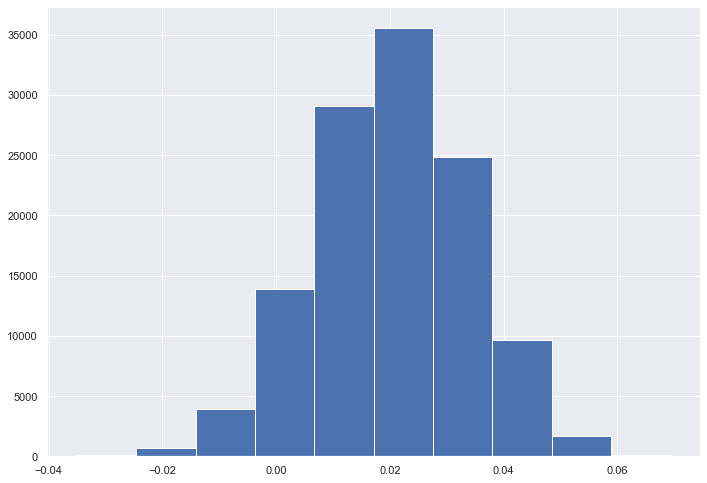

The indecision percentage around 0.02 is 0.3352659440383161
The percentage of outliers detected is 0.06591796057149557


In [10]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [11]:
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

# Feature Manipulation

In [12]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Boxcox Transformation

In [13]:
y_train, fitted_lambda= stats.boxcox(list(y_train),lmbda=None)
#print(fitted_lambda)
#print(stats.boxcox([0.7,1], fitted_lambda))
y_train = np.array(y_train)
print(fitted_lambda)

-1.0008549422054305


# Smote Sampling 

In [14]:
#quantization function required for some score functions
def quantize(x,cuts=100):
  ranges = np.sort(np.unique(pd.cut(x,cuts)))
  for i in range(ranges.shape[0]):
    ranges_i = ranges[i]
    x[(x<=ranges_i.right)&(x>ranges_i.left)] = (ranges_i.left +ranges_i.right)/2
  return x

def quantize_features(x,cuts=100):
  return np.apply_along_axis(quantize,0,x,cuts)

#correlation scorers
def Spearman(i,j):
  ret,_ = spearmanr(i,j)
  return ret

def Correlation_Score(x,y):
  x = x.T
  score = [min([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

def Correlation_Score_Max(x,y):
  x = x.T
  score = [-max([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)


In [15]:
def Furthest(x,z):
  """
  Returns the index of the sample in x which is furthest from all the samples in z
  :param x: numpy.ndarray: The array of the samples for which we seek to find the furthest
  :param z: numpy.ndarray: The array of the samples which we use as a point of reference
  :return: int: returns a single index corresponding to the furthest x
  """
  distances = []
  for i in range(x.shape[0]):
    distance = min([np.linalg.norm(j-x[i]) for j in z])
    distances.append(distance)
  return np.argmin(distances)

def PSU_undersampling(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling of the samples in the x,y arrays
  with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  C = np.mean(x,axis = 0)
  dist = np.linalg.norm(x-C,2,axis = 1)
  indices = dist.argsort()
  x = x[indices]
  y = y[indices]
  split_x = np.array_split(x,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],xi) for i in range(randomsize)]
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample,y_resample

def PSU_undersampling_reduced_dim(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling by first doing a dimensionality reduction
  of the samples in the x,y arrays with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  feature_scores =  Fisher_Score(xi,x)
  indices = np.sort((-feature_scores).argsort()[:10])
  x_filtered = x[:,indices]
  x_i = xi[:,indices]
  C = np.mean(x_filtered,axis = 0)
  dist = np.linalg.norm(x_filtered-C,2,axis = 1)
  indices = dist.argsort()
  x_filtered = x_filtered[indices]
  y = y[indices]
  split_x = np.array_split(x_filtered,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],x_i) for i in range(randomsize)]
  split_x = np.array_split(x,randomsize)
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample,y_resample

def Fisher_Score(x_import,x_nimport):
  """
  Given two arrays of two classes this function calculates the Fischer_scores to 
  measure the significance for all features
  :param x_import: numpy.ndarray: the array containing the samples of one class
  :param x_nimport: numpy.ndarray: the array containing the samples of the other class
  :return: numpy.ndarray: returns an array containg the Fisher_Score for all features 
  """
  mean_import = np.mean(x_import,axis = 0)
  mean_nimport = np.mean(x_nimport,axis = 0)
  mean_dist = np.absolute(mean_import-mean_nimport)
  std_import = np.std(x_import,axis=0)
  std_nimport = np.std(x_nimport,axis=0)
  std_sum = std_import+std_nimport
  #return std_sum
  return np.divide(mean_dist,std_sum)

def calculate_distances(x,distance):
  """
  Calculates the distance between any two pairs of the set x using 
  the Minkowski distance of degree distance.
  :param x: numpy.ndarray: the vector for which we will calculate the distance 
                            between all of its elements 
  :param distance: float: the norm which should be used for the Minkowski distance
  :return: numpy.ndarray: returns the Minkowski distance with the specified norm 
                          between all pairs of elements in x 
  """
  dist = np.array([[minkowski(a1,a2,distance) for a2 in x] for a1 in x])
  np.fill_diagonal(dist,float('inf'))
  return dist

def random_sampler(x,y,randomsize,x1,x2):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x,y,neighbors,N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def smote_sf(x, y, undersample=0.5, oversample = 0.1, attribute_scorer=Fisher_Score, 
             attribute_number = 10, distance = float('inf'), kneighbors = 3,
             undersampling = random_sampler, importance_class = 0.7):
  """
  This function takes the complete input and produces a more balanced dataset based on the importance class
  :param x: numpy.ndarray: the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param undersample: float: the percentage of the dominant class that we want to keep
  :param oversample: float: the percentage of the dataset that the small class will be at the end
  :param attribute_scorer: function: a function which will be used to score the relevance of a feature
  :param attribute_number: int: the number of attributes to keep according to their score
  :param distance: float: the norm which should be used for the Minkowski distance
  :param kneighbors: int: the number of samples which should be considered for each point 
  :param undersampling: function: the function to use for the undersampling of the majority class
  :param importance_class: float: the lower bound for the underepresented class
  :return: returns 2 new feature vectors and 2 new label vectors containing 
            the data for the importance class and the data for the non importance 
            class and their labels. 
  """
  x_import = x[y>=importance_class]
  y_import = y[y>=importance_class]
  x_nimport = x[y<importance_class]
  y_nimport = y[y<importance_class]

  feature_scores =  attribute_scorer(x_import,x_nimport)
  #find the attribute_number highest coordinates of the feature_scores vector
  indices = np.sort((-feature_scores).argsort()[:attribute_number])
  x_import_filtered = x_import[:,indices]
  #x_nimport = x_nimport[:,indices]
  distances = calculate_distances(x_import_filtered,distance)
  #find the k lowest indices
  neighbors = np.array([ np.sort(d.argsort()[:(kneighbors)]) for d in distances])
  #undersampling for the majority class
  nimport_len = int(undersample*y_nimport.shape[0])
  x_nimport,y_nimport = undersampling(x_nimport,y_nimport,nimport_len,x_import,y_import)
  #Calculate the number of samples to be generated
  N = int(oversample*(y_nimport.shape[0]) - y_import.shape[0])
  #Generate N new samples
  new_samples_x,new_samples_y = generate_samples(x_import, y_import, neighbors, N)
  #merge the new samples of the minority class with its old samples
  x_import = np.concatenate((x_import,new_samples_x))
  y_import = np.concatenate((y_import,new_samples_y))

  x_ret = np.concatenate((x_import, x_nimport))
  y_ret = np.concatenate((y_import,y_nimport))
  return x_ret, y_ret

In [16]:
importance_boundary = stats.boxcox([0.7,1.],fitted_lambda)[0]
print(importance_boundary)

-0.4286406555284001


In [ ]:
# try with the L1 norm
x_train1,y_train1 = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5, distance = 1.,undersampling = PSU_undersampling, importance_class = importance_boundary)
p = np.random.permutation(len(y_train1))
x_train1 = x_train1[p]
y_train1 = y_train1[p]

In [17]:
# try with the L2 norm
x_train2,y_train2 = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5, distance = 2.,undersampling = PSU_undersampling,attribute_scorer= Correlation_Score_Max,importance_class = importance_boundary)
p = np.random.permutation(len(y_train2))
x_train2 = x_train2[p]
y_train2 = y_train2[p]

In [ ]:
x_train,y_train = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5,undersampling = PSU_undersampling, importance_class = importance_boundary)

In [18]:
p = np.random.permutation(len(y_train))
x_train = x_train[p]
y_train = y_train[p]

In [ ]:
print(x_train2.shape,y_train2.shape)

# Metric

In [19]:
def penalized_MSE_helper(y_true, y_pred):
    critical_indices = np.where(y_true >= 0.7)[0]
    print(critical_indices)
    print(y_true,y_pred)
    if(critical_indices.shape[0]==0 | critical_indices.shape[0]==y_true.shape[0]):
        return (1/2)*MSE(y_true, y_pred)
    else:
      critical_y = y_true[critical_indices]
      common_y = np.delete(y_true, critical_indices)
      critical_predictions = y_pred[critical_indices]
      common_predictions = np.delete(y_pred, critical_indices)
      return (1/2)*MSE(critical_y, critical_predictions)+ (1/2)*MSE(common_y, common_predictions)

In [20]:
def penalized_MSE(y_true, y_pred,fitted_lambda=-1.0008549422054305):
  return penalized_MSE_helper(y_true,sci.special.inv_boxcox(y_pred, fitted_lambda))

def penalized_MSE_train(y_true, y_pred,fitted_lambda=-1.0008549422054305):
  return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))

# Training

In [ ]:
model = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model.fit(x_train, y_train,eval_metric=penalized_MSE_train)
predictions = model.predict(x_test)

In [ ]:
predictions = sci.special.inv_boxcox(predictions, fitted_lambda)

In [ ]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions))

In [ ]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

In [ ]:
model1 = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model1.fit(x_train1, y_train1,eval_metric=penalized_MSE_train)
predictions1 = model1.predict(x_test)

In [ ]:
predictions1 = sci.special.inv_boxcox(predictions1, fitted_lambda)

In [ ]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions1))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions1))

In [ ]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions1[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

In [21]:
model2 = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model2.fit(x_train2, y_train2,eval_metric=penalized_MSE_train)
predictions2 = model2.predict(x_test)

In [22]:
predictions2 = sci.special.inv_boxcox(predictions2, fitted_lambda)

In [23]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions2))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions2))

the MSE for tuned model XGB Regressor is 0.0031434697847426063
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
[0.72502145 0.79381635 0.72175077 ... 0.1444491  0.23114848 0.15589872] [3.3516295 3.2579741 2.9591987 ... 1.1780689 1.1859661 1.186692 ]
the weighted-MSE for tuned model XGB Regressor is 6.643223528361796


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


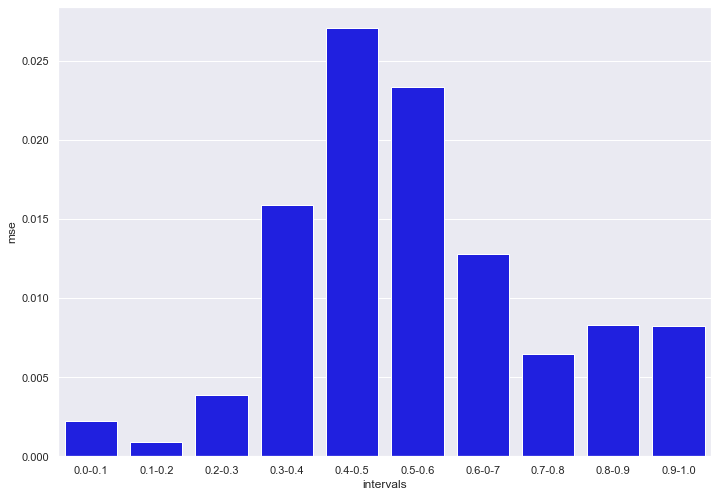

In [24]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions2[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

# Error analysis

We will try to identify in which case the model perform the worst and why. We consider an error significant if |prediction-label| > 0.15.

In [49]:
indices_significant_errors = np.where(np.abs(predictions2-y_test)>0.15)[0]
x_errors = x_test[indices_significant_errors, :]
y_errors = y_test[indices_significant_errors]
x_correct = np.delete(x_test, indices_significant_errors, axis=0)
y_correct = np.delete(y_test, indices_significant_errors, axis=0)

In [50]:
print(y_correct.shape)

(49693,)


In [51]:
print(x_test.shape)

(51175, 318)


We create a dataframe similar to the original one in which we label 1 the rows in which we made a significant error, 0 otherwise.

In [71]:
df_errors = pd.DataFrame(data=x_errors)
df_correct = pd.DataFrame(data=x_correct)
df_errors[318] = y_errors
df_correct[318] = y_correct
df_errors['label'] = 1
df_correct['label'] = 0


df_to_study = pd.concat([df_correct, df_errors], axis=0)

In [72]:
df_to_study

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,label
0,1.188327,-1.208026,1.542255,0.971060,-0.218440,-2.346372,-0.369938,1.781243,1.311671,-1.322873,...,0.459625,-0.111618,1.153822,-0.965975,-1.715336,-0.290366,-1.925853,0.994439,0.725021,0
1,-1.258938,-0.219627,0.953092,0.771183,0.078320,-0.027528,0.530971,0.602848,0.130597,-0.649598,...,0.715427,0.363721,1.291423,1.297880,-0.269716,0.866585,-1.831657,1.423588,0.793816,0
2,1.335544,1.759322,-0.107779,-1.062344,-0.994993,0.779849,0.037433,0.238903,0.420862,-0.414045,...,0.765654,-0.356145,1.209731,0.175789,0.150882,-0.781412,-0.005173,0.526481,0.721751,0
3,-1.222911,0.169884,0.160475,0.788431,-0.022223,0.526008,0.739169,0.466527,0.258260,-0.561152,...,0.492860,-1.501045,-1.679169,-1.025921,1.567099,-1.038557,0.332750,-1.259874,0.962317,0
4,-1.043524,-0.362210,0.562604,0.855808,0.149724,0.216831,0.684685,0.498679,0.418333,-0.765641,...,0.765791,-0.356109,1.209658,0.175202,0.150742,-0.781523,-0.004981,0.526193,0.801810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0.753031,-0.362151,-1.185162,0.164569,0.394285,-0.757941,-0.297486,-0.031774,1.122822,-1.137460,...,0.395289,-1.233144,-0.921225,-1.234442,1.314714,-1.162925,-0.245629,-1.744950,0.518771,1
1478,1.358131,-0.889361,1.270629,1.077979,-0.047005,-1.632423,-0.235385,1.224167,0.849724,-0.895996,...,0.454087,-1.432530,-1.629266,-0.693561,1.840548,-1.017962,0.043716,-1.629821,0.327892,1
1479,-1.101103,-0.904853,-0.470683,1.015755,0.463572,0.015122,1.147122,0.459541,0.301398,-0.578161,...,0.522310,0.619371,-1.583028,1.910230,-0.215656,1.048599,-0.624070,0.438856,0.317526,1
1480,0.887006,1.283131,-0.185821,-0.958717,-1.269288,0.537705,0.378439,0.135307,0.000036,-0.101964,...,0.682051,-0.996722,-1.565831,-0.651144,1.893265,-0.944787,-0.196998,-2.614851,0.469531,1


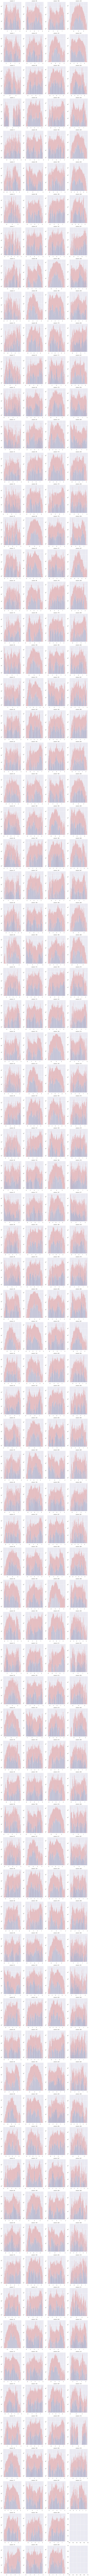

In [73]:
fig, ax = plt.subplots(80,4, figsize=(14,400))
for i in range(df_to_study.shape[1]):
    sbplt = ax[i%80, math.floor(i/80)]
    df_0 = df_to_study[df_to_study['label']==0]
    df_1 = df_to_study[df_to_study['label']==1]
    sbplt.hist(df_0.iloc[:,i], bins =100, alpha=0.5, label='correct', color='r',log=True)
    sbplt.hist(df_1.iloc[:,i], bins =100, alpha=0.5, label='error', color='b', log=True)
    sbplt.set_title('column: {}'.format(i))
fig.tight_layout()

It is difficult to notice some meaningful differences.

We will now try a different approach, we will try to project the features on a 2D dimensional space to see if the errors are kind of separable, in this case we could consider using a clustering algorithm to separate them and then using a different model for the points in which we notice an error.

In [76]:
labels = df_to_study['label'].values
X = df_to_study.drop(columns = [318,'label']).to_numpy()

In [77]:
from keras.layers import Dense, Dropout
from keras.models import Sequential, Model
from keras import metrics, Input

METRICS = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae')
]
ENCODING_DIM = 2 #Desired Dimension
BATCH_SIZE = 64
EPOCHS = 100
def make_and_train_autoencoder(X_train, metrics=METRICS):
    
    len_input_output = X_train.shape[-1]
    input_ = Input(shape=(len_input_output,))
    encoded = Dense(units=ENCODING_DIM*2, activation="relu")(input_)
    bottleneck = Dense(units=ENCODING_DIM, 
                       activation="relu")(encoded)
    decoded = Dense(units=ENCODING_DIM*2, 
                    activation="relu")(bottleneck)
    output = Dense(units=len_input_output, 
                    activation="linear")(decoded)
    #Training is performed on the entire autoencoder
    autoencoder = Model(inputs=input_, outputs=output)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',
                        metrics=[metrics])
    autoencoder.fit(X_train, X_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)
    #Use only the encoder part for dimensionality reduction
    encoder = Model(inputs=input_, outputs=bottleneck)
    return autoencoder, encoder
autoencoder, encoder = make_and_train_autoencoder(X)

Epoch 1/100
800/800 [==============================] - 1s 1ms/step - loss: 0.8661 - rms: 0.9300 - mae: 0.7677
Epoch 2/100
800/800 [==============================] - 1s 932us/step - loss: 0.7328 - rms: 0.8560 - mae: 0.6944
Epoch 3/100
800/800 [==============================] - 1s 951us/step - loss: 0.7186 - rms: 0.8477 - mae: 0.6856
Epoch 4/100
800/800 [==============================] - 1s 922us/step - loss: 0.7013 - rms: 0.8374 - mae: 0.6739
Epoch 5/100
800/800 [==============================] - 1s 940us/step - loss: 0.6873 - rms: 0.8290 - mae: 0.6636 0s - loss: 0.6828 - rms: 0.8263
Epoch 6/100
800/800 [==============================] - 1s 925us/step - loss: 0.6799 - rms: 0.8245 - mae: 0.6580
Epoch 7/100
800/800 [==============================] - 1s 920us/step - loss: 0.6753 - rms: 0.8217 - mae: 0.6543
Epoch 8/100
800/800 [==============================] - 1s 945us/step - loss: 0.6732 - rms: 0.8205 - mae: 0.6527
Epoch 9/100
800/800 [==============================] - 1s 983us/step - los

800/800 [==============================] - 1s 957us/step - loss: 0.6485 - rms: 0.8053 - mae: 0.6425
Epoch 73/100
800/800 [==============================] - 1s 954us/step - loss: 0.6487 - rms: 0.8054 - mae: 0.6429
Epoch 74/100
800/800 [==============================] - 1s 940us/step - loss: 0.6483 - rms: 0.8052 - mae: 0.6426
Epoch 75/100
800/800 [==============================] - 1s 927us/step - loss: 0.6473 - rms: 0.8046 - mae: 0.6419
Epoch 76/100
800/800 [==============================] - 1s 952us/step - loss: 0.6475 - rms: 0.8047 - mae: 0.6421
Epoch 77/100
800/800 [==============================] - 1s 1ms/step - loss: 0.6488 - rms: 0.8055 - mae: 0.6427
Epoch 78/100
800/800 [==============================] - 1s 1ms/step - loss: 0.6465 - rms: 0.8040 - mae: 0.6415
Epoch 79/100
800/800 [==============================] - 1s 2ms/step - loss: 0.6469 - rms: 0.8043 - mae: 0.6419
Epoch 80/100
800/800 [==============================] - 1s 1ms/step - loss: 0.6485 - rms: 0.8053 - mae: 0.6426
Epoc

In [93]:
X_reduced = np.array(encoder(X))

In [94]:
print(X_reduced)

[[5.524226   1.2832778 ]
 [5.562053   1.6679995 ]
 [5.388462   1.170687  ]
 ...
 [4.6812744  4.272983  ]
 [4.0172043  0.86505634]
 [4.872899   2.2322562 ]]


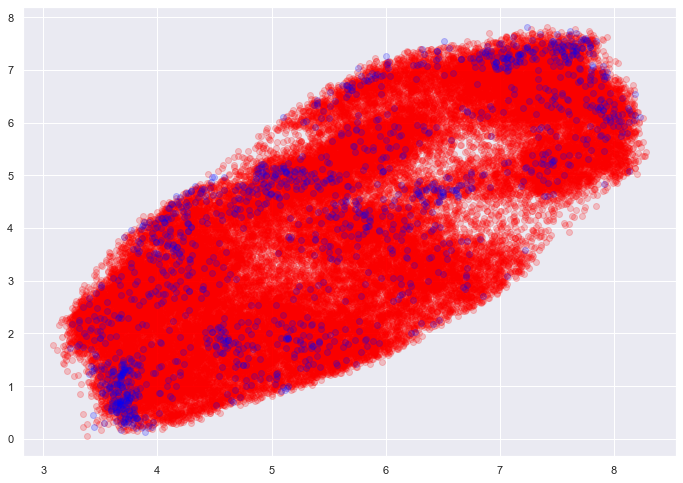

In [95]:
X_reduced_correct = X_reduced[np.where(labels==0)[0]]
X_reduced_error = X_reduced[np.where(labels==1)[0]]
plt.scatter(X_reduced_correct[:,0], X_reduced_correct[:,1], color='red', alpha=0.2)
plt.scatter(X_reduced_error[:,0], X_reduced_error[:,1], color='blue', alpha=0.2)
plt.show()

We try to understand if we could cluster data after we dilatate.

In [96]:
X_reduced_correct = X_reduced_correct*100
X_reduced_error = X_reduced_error*100

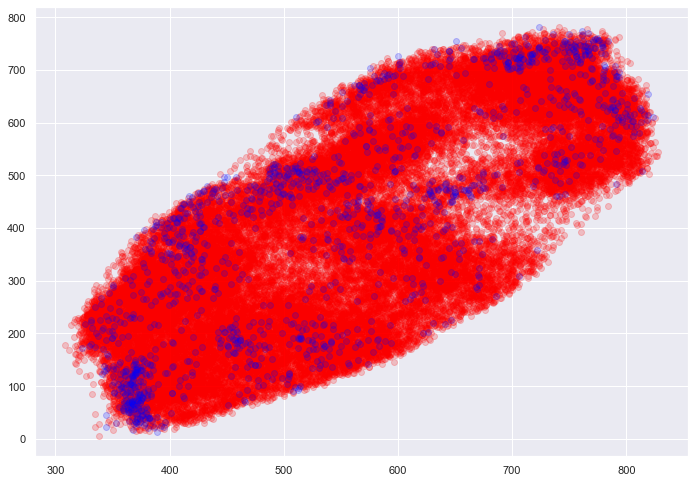

In [97]:
plt.scatter(X_reduced_correct[:,0], X_reduced_correct[:,1], color='red', alpha=0.2)
plt.scatter(X_reduced_error[:,0], X_reduced_error[:,1], color='blue', alpha=0.2)
plt.show()

In [100]:
X_reduced_error_interesting = X_reduced_error[np.where((X_reduced_error[:,0]<400) & (X_reduced_error[:,1]<200))[0], :]
X_reduced_correct_interesting = X_reduced_correct[np.where((X_reduced_correct[:,0]<400) & (X_reduced_correct[:,1]<200))[0], :]

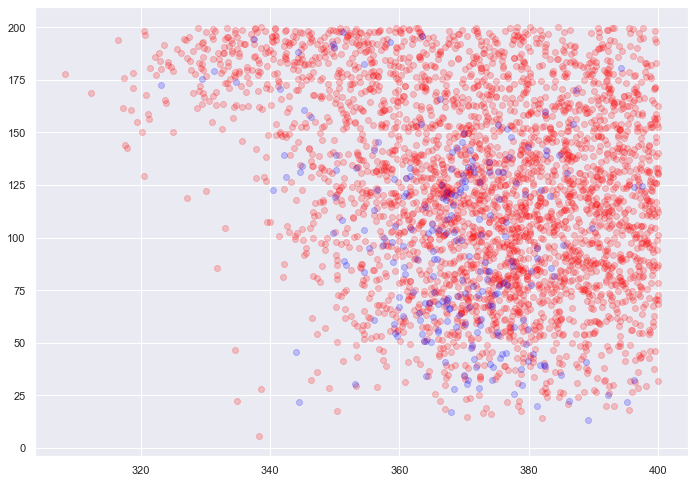

In [101]:
plt.scatter(X_reduced_correct_interesting[:,0], X_reduced_correct_interesting[:,1], color='red', alpha=0.2)
plt.scatter(X_reduced_error_interesting[:,0], X_reduced_error_interesting[:,1], color='blue', alpha=0.2)
plt.show()

# Cross validation

In [ ]:
params = { 'max_depth': [5, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.5, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
           'n_estimators': [100,500,1000]
            }

score = make_scorer(penalized_MSE_train, greater_is_better=False)
model = XGBRegressor(tree_method='gpu_hist',seed = 20)
clf = RandomizedSearchCV(estimator = model,
                         param_distributions = params,
                         scoring = score,
                         n_iter=10,
                         verbose=10)
clf.fit(x_train, y_train,eval_metric = penalized_MSE_train)

In [ ]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions))

In [ ]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()